Epoch 1/50
12/12 [==============================] - 2s 49ms/step - loss: 0.0480 - val_loss: 0.0509
Epoch 2/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0231 - val_loss: 0.0602
Epoch 3/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0211 - val_loss: 0.0842
Epoch 4/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0180 - val_loss: 0.2461
Epoch 5/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0182 - val_loss: 0.1657
Epoch 6/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0178 - val_loss: 0.1311
Epoch 7/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0173 - val_loss: 0.1805
Epoch 8/50
12/12 [==============================] - 0s 22ms/step - loss: 0.0160 - val_loss: 0.1783
Epoch 9/50
12/12 [==============================] - 0s 22ms/step - loss: 0.0159 - val_loss: 0.1220
Epoch 10/50
12/12 [==============================] - 0s 22ms/step - loss: 0.0164 - val_loss: 0.1530
Epoch 11/

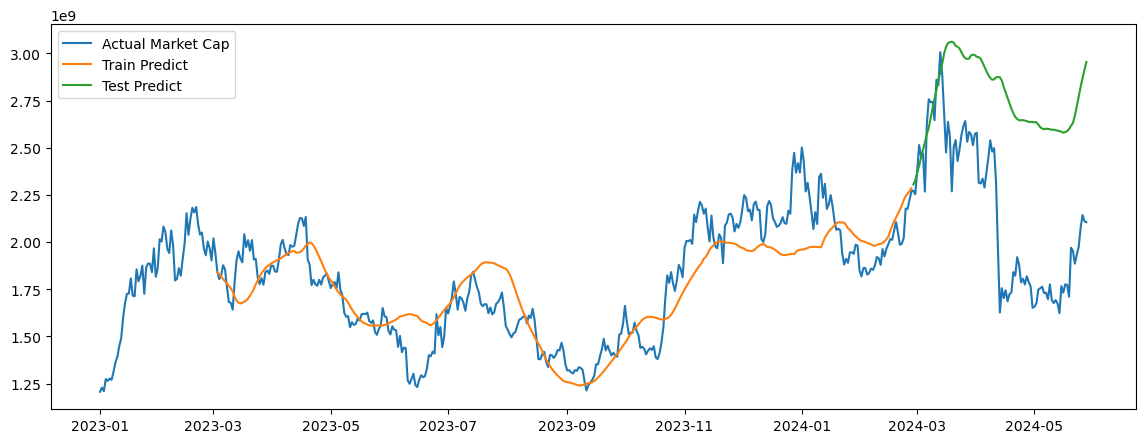

In [6]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

API_KEY = '2acb79dd-f8ca-48b5-b10c-bbee2290ed94'
BASE_URL = 'https://api.tokenterminal.com/v2'

def fetch_projects():
    url = f'{BASE_URL}/projects'
    headers = {
        'Authorization': f'Bearer {API_KEY}'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()

def fetch_metrics():
    url = f'{BASE_URL}/metrics'
    headers = {
        'Authorization': f'Bearer {API_KEY}'
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()

def fetch_time_series_data(metric_ids, project_ids, start_date, end_date):
    cache = {project_id: [] for project_id in project_ids}
    project_ids_str = ','.join(project_ids)
    
    for metric_id in metric_ids:
        url = f'{BASE_URL}/metrics/{metric_id}'
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        params = {
            'project_ids': project_ids_str,
            'start': start_date,
            'end': end_date
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 404:
            print(f"Data for projects or metric ID '{metric_id}' not found.")
            continue
        response.raise_for_status()
        data = response.json()['data']
        
        for entry in data:
            cache[entry['project_id']].append(entry)
    
    for project_id in cache:
        if cache[project_id]:
            df = pd.DataFrame(cache[project_id])
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.pivot(index='timestamp', columns='metric_id', values='value')
            df.reset_index(inplace=True)
            cache[project_id] = df
        else:
            cache[project_id] = pd.DataFrame()
    
    return cache

def add_total(data_dict):
    total_df = pd.DataFrame()
    for project_id, df in data_dict.items():
        if not df.empty:
            if total_df.empty:
                total_df = df[['timestamp']].copy()
                total_df.set_index('timestamp', inplace=True)
                total_df['market_cap_fully_diluted'] = 0
                total_df['earnings'] = 0
                total_df['tvl'] = 0
            
            total_df = total_df.join(df.set_index('timestamp'), how='outer', rsuffix=f'_{project_id}')
            total_df['market_cap_fully_diluted'] += total_df[f'market_cap_fully_diluted_{project_id}'].fillna(0)
            total_df['earnings'] += total_df[f'earnings_{project_id}'].fillna(0)
            total_df['tvl'] += total_df[f'tvl_{project_id}'].fillna(0)
    
    total_df.reset_index(inplace=True)
    total_df = total_df[['timestamp', 'market_cap_fully_diluted', 'earnings', 'tvl']]
    total_df.sort_values('timestamp', inplace=True)
    total_df.reset_index(drop=True, inplace=True)
    data_dict['total'] = total_df

    return data_dict

projects = fetch_projects()
metrics = fetch_metrics()

projects_df = pd.DataFrame(projects['data'])
metrics_df = pd.DataFrame(metrics['data'])

metric_ids = ['market_cap_fully_diluted', 'earnings', 'tvl']
project_ids = ['aave','gmx','hmx']
start_date = '2023-01-01'
end_date = '2024-05-28'

time_series_data = fetch_time_series_data(metric_ids, project_ids, start_date, end_date)
time_series_data = add_total(time_series_data)

# Assuming `total_df` is your DataFrame from the previous step
total_df = time_series_data['total']

# Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(total_df[['market_cap_fully_diluted', 'earnings', 'tvl']])

# Preparing the data for the LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 1:]  # Earnings and TVL
        X.append(a)
        Y.append(data[i + time_step, 0])  # Market Cap Fully Diluted
    return np.array(X), np.array(Y)

time_step = 60  # You can adjust this
X, Y = create_dataset(scaled_data, time_step)

# Reshaping the data to fit the LSTM model (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 2)

# Splitting the data into training and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 2)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Predicting and inverse transforming the results
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverting the predictions
train_predict_full = np.concatenate((train_predict, X_train[:, -1, :]), axis=1)
test_predict_full = np.concatenate((test_predict, X_test[:, -1, :]), axis=1)

train_predict_full = scaler.inverse_transform(train_predict_full)[:, 0]
test_predict_full = scaler.inverse_transform(test_predict_full)[:, 0]

# Evaluating the model
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(total_df['timestamp'], total_df['market_cap_fully_diluted'], label='Actual Market Cap')
plt.plot(total_df['timestamp'][time_step+1:train_size+time_step+1], train_predict_full, label='Train Predict')
plt.plot(total_df['timestamp'][train_size+time_step+1:], test_predict_full, label='Test Predict')
plt.legend()
plt.show()
